## 순환신경망 모델

In [1]:
import requests
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
%matplotlib inline
model_path = './'
target_col='price'

In [2]:
data = pd.read_csv("D:/학교/4학년/1학기/캡스톤디자인/농산물 유통정보/대파/data.csv")

In [3]:
data.index = data['date']
del data['date']
del data['Unnamed: 0']
data.head(3)

,평균기온(°C),최저기온(°C),최고기온(°C),생산량,price
date,,,,,
2010-01-04,-0.3,-3.9,4.8,610578000.0,2232
2010-01-05,-5.1,-5.9,-1.9,610578000.0,2216
2010-01-06,-4.9,-6.1,-3.7,610578000.0,2267


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [5]:
train, test = train_test_split(data, test_size=0.2)

In [6]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

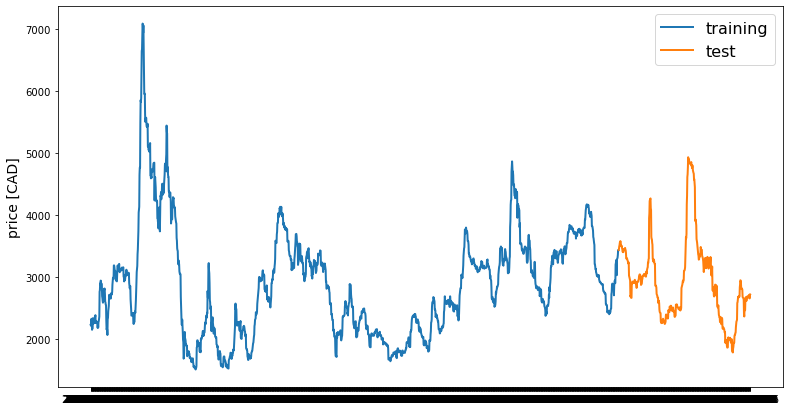

In [7]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [8]:
#정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['평균기온(°C)','최저기온(°C)','최고기온(°C)','생산량','price']
learn_data_scaled = scaler.fit_transform(data[scale_cols])

learn_data_scaled = pd.DataFrame(learn_data_scaled, index = data.index)
learn_data_scaled.columns = scale_cols

In [9]:
train, test = train_test_split(learn_data_scaled, test_size=0.2)

In [10]:
def make_dataset(data, label, window_size=30):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [11]:
feature_cols = ['평균기온(°C)','최저기온(°C)','최고기온(°C)','생산량']
label_cols = ['price']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 30)

test_feature = test[feature_cols]
test_label = test[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 30)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

In [12]:
model = Sequential()
model.add(LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=300, 
                    batch_size=10,
                    shuffle=False,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
143/149 [===========================>..] - ETA: 0s - loss: 0.0236
Epoch 00001: val_loss improved from inf to 0.02494, saving model to .\tmp_checkpoint.h5
149/149 [==============================] - 1s 6ms/step - loss: 0.0232 - val_loss: 0.0249
Epoch 2/300
146/149 [============================>.] - ETA: 0s - loss: 0.0195
Epoch 00002: val_loss improved from 0.02494 to 0.02388, saving model to .\tmp_checkpoint.h5
149/149 [==============================] - 1s 5ms/step - loss: 0.0193 - val_loss: 0.0239
Epoch 3/300
139/149 [==========================>...] - ETA: 0s - loss: 0.0185
Epoch 00003: val_loss improved from 0.02388 to 0.02230, saving model to .\tmp_checkpoint.h5
149/149 [==============================] - 1s 5ms/step - loss: 0.0182 - val_loss: 0.0223
Epoch 4/300
142/149 [===========================>..] - ETA: 0s - loss: 0.0169
Epoch 00004: val_loss improved from 0.02230 to 0.01984, saving model to .\tmp_checkpoint.h5
149/149 [==============================] - 1s 4ms/step - 

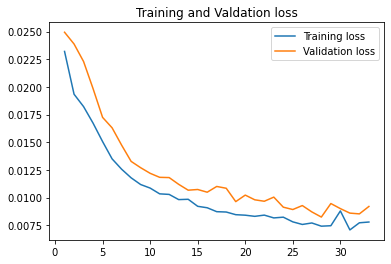

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

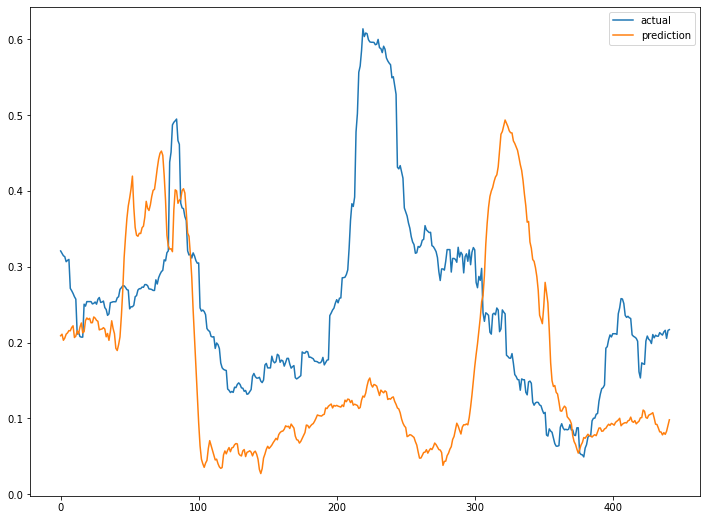

In [15]:
# 예측
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(test_label, pred)
mse = mean_squared_error(test_label, pred)
rmse = np.sqrt(mse)

In [17]:
predict_score = []
predict_score = pd.DataFrame(predict_score, columns = ['MAE','MSE','RMSE'])

In [18]:
predict_score = pd.DataFrame(data=[[mae,mse,rmse]], columns=['MAE','MSE','RMSE'])

In [19]:
predict_score

,MAE,MSE,RMSE
0,0.147437,0.034545,0.185864
